# **Data Preparation and Analysis**

### **Introduction to Data**

The data set at hand is divided into three different trials 95-trial, 100-trial and a 150-trial. There is three seperate csv files per trial. Let's take the 95-trial we have a csv file that records the participants choices, a csv file that records the participants losses and a csv file that records the participants winnings.

As all of the data isn't gathered from one study it is in fact gathered from 10 seperate studies we are also given a fourth csv file which maps what study each participant took part in.

The studies differ in many ways from the size of the actual trials to the age demographics of the studies.

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import seaborn as sns

import matplotlib.pyplot as plt

from numpy import arange

import sklearn
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

import sklearn.metrics as sm
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
#Focusing on 100 choices from 200 subjects as a first step
choice95 = pd.read_csv('Data\choice_95.csv')
win95 = pd.read_csv('Data\wi_95.csv')
loss95 = pd.read_csv("Data\lo_95.csv")
index95 = pd.read_csv("Data\index_95.csv")
choice100 = pd.read_csv('Data\choice_100.csv')
win100 = pd.read_csv('Data\wi_100.csv')
loss100 = pd.read_csv("Data\lo_100.csv")
index100 = pd.read_csv("Data\index_100.csv")
choice150 = pd.read_csv('Data\choice_150.csv')
win150 = pd.read_csv('Data\wi_150.csv')
loss150 = pd.read_csv("Data\lo_150.csv")
index150 = pd.read_csv("Data\index_150.csv")

In [3]:
df95 = pd.DataFrame()
df100 = pd.DataFrame()
df150 = pd.DataFrame()

df95["Total W"] = win95.sum(axis=1)
df95["Total L"] = loss95.sum(axis=1)

df100["Total W"] = win100.sum(axis=1)
df100["Total L"] = loss100.sum(axis=1)

df150["Total W"] = win150.sum(axis=1)
df150["Total L"] = loss150.sum(axis=1)

df95.reset_index(inplace=True)
df100.reset_index(inplace=True)
df150.reset_index(inplace=True)

df95["Study"] = index95["Study"].values
df100["Study"] = index100["Study"].values
df150["Study"] = index150["Study"].values

df95["Margin"] = df95["Total W"] + df95["Total L"]
df100["Margin"] = df100["Total W"] + df100["Total L"]
df150["Margin"] = df150["Total W"] + df150["Total L"]

df95.size + df100.size + df150.size #2468

final = pd.DataFrame()
alternative = pd.DataFrame()
alternative = df95.append(df100)
final = alternative.append(df150)
final.size #2468
#final.to_csv("Data/whole_clustering.csv")
final.head()

,index,Total W,Total L,Study,Margin
0,Subj_1,5800,-4650,Fridberg,1150
1,Subj_2,7250,-7925,Fridberg,-675
2,Subj_3,7100,-7850,Fridberg,-750
3,Subj_4,7000,-7525,Fridberg,-525
4,Subj_5,6450,-6350,Fridberg,100


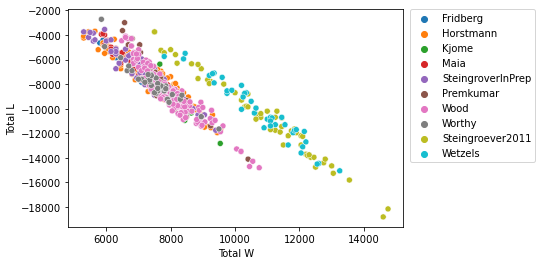

In [4]:
sns.scatterplot(data=final, x="Total W", y="Total L", hue="Study")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

No handles with labels found to put in legend.


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Fridberg'),
  Text(1, 0, 'Horstmann'),
  Text(2, 0, 'Kjome'),
  Text(3, 0, 'Maia'),
  Text(4, 0, 'SteingroverInPrep'),
  Text(5, 0, 'Premkumar'),
  Text(6, 0, 'Wood'),
  Text(7, 0, 'Worthy'),
  Text(8, 0, 'Steingroever2011'),
  Text(9, 0, 'Wetzels')])

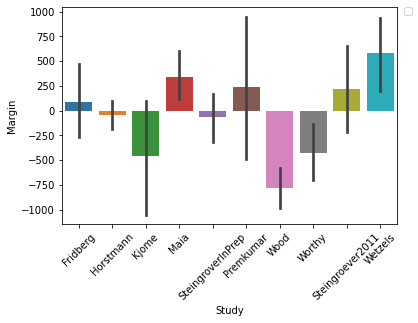

In [5]:
sns.barplot(x="Study", y="Margin", data=final)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xticks(rotation=45)

From my above data analysis I can see that one study in particular whose margins were surprising. The Wood study in both graphs shows that participants were making considerable losses. Upon inspection this study was ran on two different groups of people. The first 90 participants were between the ages of 18-40 with the remaining 62 participants between the ages of 61-88. My proposal is to look at the difference between the two age groups and see whether the younger participants were quicker to identify the beneficial cards.

In [6]:
choice_new = choice100.apply(pd.Series.value_counts, axis=1)
choice_new.columns = ["A", "B", "C", "D"]
choice_new.fillna(value = 0, inplace = True)
choice_new.A = choice_new.A.astype(int)
choice_new.B = choice_new.B.astype(int)
choice_new.C = choice_new.C.astype(int)
choice_new.D = choice_new.D.astype(int)
choice_new["Study"] = index100["Study"].values

In [7]:
choice_new["Total-B/D"] = choice_new["B"] + choice_new["D"]

In [8]:
young = choice_new[0:91]
a = young["A"].sum()
b = young["B"].sum()
c = young["C"].sum()
d = young["D"].sum()


data = [{'A': a, 'B': b, 'C':c, "D":d}]
young_stats = pd.DataFrame(data)
young_stats = young_stats.rename(index={0: 'Counts'})

In [9]:
old = choice_new[91:]
a = old["A"].sum()
b = old["B"].sum()
c = old["C"].sum()
d = old["D"].sum()

data = [{'A': a, 'B': b, 'C':c, "D":d}]
old_stats = pd.DataFrame(data)
old_stats = old_stats.rename(index={0: 'Counts'})

In [10]:
win100['Total'] = win100.sum(axis=1)
loss100['Total'] = loss100.sum(axis=1)

The subject dataframe I will use to cluster only the Wood study. This study was ran on two seperate groups with different ages so will hopefully provide interesting results.

In [11]:
subject = pd.DataFrame(columns=["Subjects"])
subject["Subjects"] = win100.index
subject["Difference"] = win100["Total"].values + loss100["Total"].values
subject["Total-B/D"] = choice_new["Total-B/D"].values/100 * 100
subject["Study"] = index100["Study"].values
subject = subject[subject.Study == "Wood"]
subject["AgeProfile"] = ""
subject.AgeProfile.values[:91] = "Young"
subject.AgeProfile.values[91:] = "Old"
subject.tail(20)

,Subjects,Difference,Total-B/D,Study,AgeProfile
449,Subj_450,-1420,50.0,Wood,Old
450,Subj_451,-595,60.0,Wood,Old
451,Subj_452,-470,51.0,Wood,Old
452,Subj_453,2360,33.0,Wood,Old
453,Subj_454,-565,66.0,Wood,Old
454,Subj_455,-1510,57.0,Wood,Old
455,Subj_456,-2475,77.0,Wood,Old
456,Subj_457,-1860,75.0,Wood,Old
457,Subj_458,-2330,63.0,Wood,Old
458,Subj_459,2480,73.0,Wood,Old


The dataset had a larger representation of younger people, from the scatter plot above you can clearly see that there are more older nodes making extreme loses and percentage wise more older people losing money. From my initial data analysis it seems as though in general the younger people were quicker to figure out that the B card and the D card were

In [12]:
#This is the dataset that we will be using for our clustering of the wood study
subject.to_csv("Data/clustering.csv")

#This is the dataset we will be using for the whole study clustering
final.to_csv("Data/whole_clustering.csv")